<a href="https://colab.research.google.com/github/iskra3138/ImageSr/blob/master/2_TFRecord_%ED%8C%8C%EC%9D%BC_%EB%A7%8C%EB%93%A4%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

참고 : https://codelabs.developers.google.com/codelabs/keras-flowers-data/#4

5종의 꽃 이미지 데이터를 TFRecord로 만드는 예제 코드입니다.

TFRecord만 만들 경우에는 GPU를 사용하지 않습니다. CPU instance만으로 가능합니다.

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path

In [0]:
# 폴더 구조를 쉽게 보기 위해서 tree 설치
!apt-get install tree

In [0]:
#@title "display utilities [RUN ME!!!]"
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(label.numpy().decode("utf-8"), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

## The flowers dataset
![대체 텍스트](https://lh5.googleusercontent.com/jXellwfrqrvoGPJeMQM29EyaZfaAC3dO2rF1cmTlZxBG2IyfVNHFEZsDVEciGXVgBFaQJZkJ4Ss5kRAG8qwK6zUuGrI_Pgus0SqVbvLYIGpiyIniQ6qz9q9nl1-szrEBzT4IjMaK)
![대체 텍스트](https://lh4.googleusercontent.com/8_jOXRV3Y2vBT72C1IdUz04pfSqWyP5Dkq5NvIFwn9fNhfC2XknnHKhCHvd-hISiEVNrLmNflYwPOHgpYcE1rwCA7Xqpw4HnbMfLimFOs-zl7nuA2OxdxhMi5tOlnDG_WCy4_Cer)
![대체 텍스트](https://lh5.googleusercontent.com/J-lCrbQC6EQDulmGbhiUO1cg4LcaYqV-BOsGfN_UvnaFLHyzGBHsio1mUqYx_wR_KTDaa6_crVfjdqtyeQoQjcwN4lFSAw0Yp7JqMiB-yFvSm7YHIEBIlKAAFkVe2GhGBMgvqSLW)</br>
![대체 텍스트](https://lh3.googleusercontent.com/rsCQsIY26YvQpm67UfUX_yDGfE2JrBTg86EFfLZBJKpocOh3zVMwvbIjc_Z82HByLmok_TgYZ6RyLXoGmTAnKyKpGDsTY_7vHHP4Zivhn-YwucLD4H6aSw94qbdW6lAhWna1ClH1)
![대체 텍스트](https://lh3.googleusercontent.com/og36ajmNenXx1SRP95HIGXZ7GlF06QoySLNpHFbgQD_bqUi7hBss84l4-M-90y0L49mvVosiPbFY5izlPHFDNh0o-t-jC2wun_DQvel1e4nGx8wWBPlJ7xCHlAQZpWzT7wEI_Yt4)
![대체 텍스트](https://lh5.googleusercontent.com/z1PsDwOjFUhR16wAs_9CSrEsq_y479ZASzQUKti620KMraMGXRqUXtCl8sMGq6Hou5XuLjN1crBB747mMk_o-YW-u0K1a7UYoOPG_85EnN0p3guJsDTD3NqkGOS4iMCkudwhDTer)

The flowers dataset consists of images of flowers with 5 possible class labels.

In [9]:
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = Path(data_dir)

228818944/228813984 [==============================] - 1s 0us/step


In [10]:
!tree -d {str(data_dir)}

/root/.keras/datasets/flower_photos
├── daisy
├── dandelion
├── roses
├── sunflowers
└── tulips

5 directories


In [0]:
SHARDS = 16 # TFRecord 파일을 16개 만들겠음
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips'] # do not change, maps to the labels in the data (folder names)

AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

DataSet나누고 TFRecord 만들기
- Train Data와 Vaildation Data를 파일 단위로 사전에 나눈 후 Train용 TFrecord파일, Validatino용 TFRecord파일을 별도로 만들 수도 있고
- 여기서처럼, 모든 데이터를 통째로 섞어서 여러 개의 TFrecord파일을 만든 후, 학습 시, TFrecord 파일을 임의로 분리해서 Train용/Validation용으로 사용할 수 있음
  - 이렇게 여러 개의 TFrecord 파일을 만들 경우 Cross validation이 좀 더 용이함

In [12]:
## 총 3670장의 이미지를 16개의 TFrecord 파일로 만들려면 한 파일당 230개가 필요(마지막은 220)
nb_images = len(tf.io.gfile.glob(str(Path(data_dir / '*/*.jpg')))) # 총 이미지 데이터 수 count
shard_size = math.ceil(1.0 * nb_images / SHARDS)
print("Pattern matches {} images which will be rewritten as {} .tfrec files containing {} images each.".format(nb_images, SHARDS, shard_size))

Pattern matches 3670 images which will be rewritten as 16 .tfrec files containing 230 images each.


In [0]:
# 개별 file로부터 얻고자 하는 정보가 있다면 'read_file_and_label' 함수에 정의합니다.
def read_file_and_label(filename):
  image_bits = tf.io.read_file(filename)## image_bits는 string으로 됩니다.
  
  # parse flower name from containing directory
  split_name = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='/')
  file_name = split_name.values[-1] ## file_name은 파일명, 즉 string으로 됩니다. (향후 TFRecord 파일 만으로도 이미지의 이름을 알기 위해 추가했습니다.)
  label_name = split_name.values[-2] ## label_name은 폴더명, 즉 string으로 됩니다.
  label = tf.where(np.array(CLASSES)==label_name)[0][0] ## label은 integer가 됩니다.
  
  return image_bits, file_name, label_name, label

filenames = tf.data.Dataset.list_files(str(Path(data_dir / '*/*.jpg')), seed=35155) # This also shuffles the images
dataset1 = filenames.map(read_file_and_label, num_parallel_calls=AUTO)
dataset1 = dataset1.batch(shard_size) # 한 번에 230장씩 꺼내서 하나의 파일을 만들게 됩니다.

In [14]:
# Three types of data can be stored in TFRecords: bytestrings, integers and floats
# They are always stored as lists, a single data element will be a list of size 1

def _bytestring_feature(list_of_bytestrings): # string
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
  return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def _float_feature(list_of_floats): # float32
  return tf.train.Feature(float_list=tf.train.FloatList(value=list_of_floats))
  

def to_tfrecord(tfrec_filewriter, img_bytes, file_name, label_name, label):  
  feature = {
      "image": _bytestring_feature([img_bytes]), # one image in the list
      "file_name": _bytestring_feature([file_name]),     # fixed length (1) list of strings, the text label
      "label_name": _bytestring_feature([label_name]),     # fixed length (1) list of strings, the text label
      "label": _int_feature([label]),     # fixed length (1) list of strings, the text label
      
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))
  
print("Writing TFRecords")

for shard, (bits, file_name, label_name, label) in enumerate(dataset1):
  # batch size used as shard size here
  shard_size = bits.numpy().shape[0] # Batch의 개수(즉, 230, 마지막은 220)
  # good practice to have the number of records in the filename
  filename = './' + "{:02d}-{}.tfrec".format(shard, shard_size)
  
  with tf.io.TFRecordWriter(filename) as out_file:
    for i in range(shard_size):
      example = to_tfrecord(out_file,
                            bits.numpy()[i], 
                            file_name.numpy()[i],
                            label_name.numpy()[i],
                            label.numpy()[i]
                            )
      out_file.write(example.SerializeToString())
    print("Wrote file {} containing {} records".format(filename, shard_size))

Writing TFRecords
Wrote file ./00-230.tfrec containing 230 records
Wrote file ./01-230.tfrec containing 230 records
Wrote file ./02-230.tfrec containing 230 records
Wrote file ./03-230.tfrec containing 230 records
Wrote file ./04-230.tfrec containing 230 records
Wrote file ./05-230.tfrec containing 230 records
Wrote file ./06-230.tfrec containing 230 records
Wrote file ./07-230.tfrec containing 230 records
Wrote file ./08-230.tfrec containing 230 records
Wrote file ./09-230.tfrec containing 230 records
Wrote file ./10-230.tfrec containing 230 records
Wrote file ./11-230.tfrec containing 230 records
Wrote file ./12-230.tfrec containing 230 records
Wrote file ./13-230.tfrec containing 230 records
Wrote file ./14-230.tfrec containing 230 records
Wrote file ./15-220.tfrec containing 220 records


## TFRecord 저장
- Google colab은 런타임 지속시간 제약이 있으므로, 향후 활용을 위해서는 어딘가에 저장을 해야 합니다.
- Google Drive가 무료라 활용을 많이 했는데, 최근 Heavy하게 사용하다 보니 IO Error가 지속적으로 발생합니다. 
  - colab FAQ에도 이와 관련된 내용이 정식으로 올라왔습니다.
  
    ```간혹 drive.mount()가 실패하면서 '시간 초과' 메시지가 표시되는 이유와 drive.mount()로 마운트된 폴더에서 I/O 작업이 실패하는 이유는 무엇인가요?```
- 현재로서는 GCP에 Bucket을 생성하고 TFrecord파일들을 저장한 후, 사용하는 것이 가장 효과적인 것 같습니다.
  - TPU 사용은 무조건 TFrecord파일이 GCP Bucket에 위치해야 합니다. 
  - GCP에서 Storage만 이용하면 요금이 매우 저렴한 걸로 알고 있습니다. [Bucket 요금 정책](https://cloud.google.com/storage/pricing?hl=ko#prorate) 
  - GCP에 Bucket을 만들고 저장하는 것은 [3, Bucket 관련 colab 노트]()를 참조해주세요
  - 본 예제는 GCP Bucket이 만들어졌고, 공개되었다는 가정하에 이어집니다. 

In [0]:
def read_tfrecord(example, TARGET_SIZE):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "file_name": tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "label_name": tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "label": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar, one integer
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.image.resize(image, TARGET_SIZE)
    image = tf.image.convert_image_dtype(image, tf.float32) ## make [0,255] to [0,1)
    
    file_name  = example['file_name']
    label_name  = example['label_name']
    label  = example['label']
    
    return image, file_name, label_name, label
    
# read from TFRecords. For optimal performance, read from multiple
# TFRecord files at once and set the option experimental_deterministic = False
# to allow order-altering optimizations.

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

filenames = tf.io.gfile.glob("./*.tfrec")
dataset2 = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
dataset2 = dataset2.with_options(option_no_order)

dataset2 = dataset2.map(lambda x: read_tfrecord(x, [128,128]), num_parallel_calls=AUTO)
dataset2 = dataset2.shuffle(300)

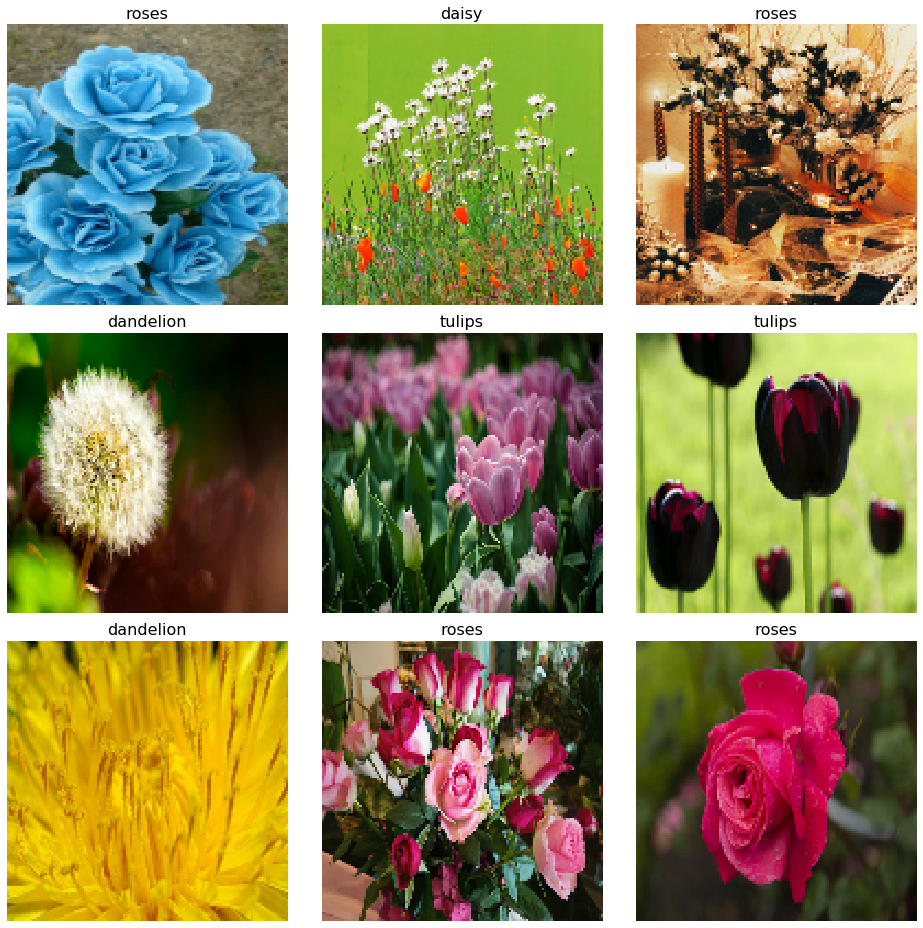

In [69]:
display_dataset = dataset2.map(lambda image, file_name, label_name, label: (image, label_name))
display_9_images_from_dataset(display_dataset)

In [70]:
for image, file_name, label_name, label in dataset2.take(300):
  print("Image shape {}, ({:>30},), ({:>10},), {}".format(image.numpy().shape, file_name.numpy().decode('utf8'), label_name.numpy().decode('utf8'), label.numpy()))

Image shape (128, 128, 3), (   3990746027_338ee436d2_n.jpg,), (    tulips,), 4
Image shape (128, 128, 3), (   5628515159_6b437ff1e5_n.jpg,), ( dandelion,), 1
Image shape (128, 128, 3), (   5139971615_434ff8ed8b_n.jpg,), (sunflowers,), 3
Image shape (128, 128, 3), (     4300258119_b03f2f956e.jpg,), (    tulips,), 4
Image shape (128, 128, 3), (   3526860692_4c551191b1_m.jpg,), (     roses,), 2
Image shape (128, 128, 3), (   6958343928_7e596da4ed_m.jpg,), (    tulips,), 4
Image shape (128, 128, 3), (  20622485918_90fc000c86_n.jpg,), (     roses,), 2
Image shape (128, 128, 3), (    17040847367_b54d05bf52.jpg,), (     roses,), 2
Image shape (128, 128, 3), (   6989946990_62c639ff16_n.jpg,), (    tulips,), 4
Image shape (128, 128, 3), (    112650879_82adc2cc04_n.jpg,), (    tulips,), 4
Image shape (128, 128, 3), (    10841136265_af473efc60.jpg,), (     daisy,), 0
Image shape (128, 128, 3), (   8691437509_9ac8441db7_n.jpg,), ( dandelion,), 1
Image shape (128, 128, 3), (      510874382_f7e34350